# U.S. Medical Insurance Costs

In this project, I will be analyzing the 'insurance.csv' file provided by Codeacademy. This file contains insurance information about individuals. Lets take a look by reading the csv using pandas.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
raw_csv_data = pd.read_csv('insurance.csv')

In [3]:
raw_csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


From intial inspection, there do not appear to be any null values, though we will need to confirm that all entries are meaningful. Lets take a look at the type of values that are in each of these columns.

In [4]:
raw_csv_data.sample(1)

,age,sex,bmi,children,smoker,region,charges
802,21,male,22.3,1,no,southwest,2103.08


In [5]:
raw_csv_data['sex'].unique()

array(['female', 'male'], dtype=object)

In [6]:
raw_csv_data['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [7]:
raw_csv_data['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

Each record (row) is information about a single patient. There are 7 columns, each representing a different characteristic:
   - **Age**: Age of the individual
        - Presumably measured in years (rounded down)
        - Presumably measured according to western standards (age at birth = 0)
   - **Sex**: Biological sex of the individual
        - Binary (male/female)
   - **BMI**: Body mass index
        - Broadly used to categorize an individuals weight
        - Formula: body mass divided by the square of the body height in units of (kg/m$^2$)
        - Continuous decimal values are commonly categorized as:
            - Underweight (<18.5 kg/m$^2$)
            - Normal Weight (>= 18.5 & < 25)
            - Overweight (>= 25 & < 30)
            - Obese (>= 30)
   - **Children**: Number of children
       - Presumably biological
   - **Smoker**: Whether or not an individual is a 'smoker' or not
       - Binary, but not additional information on what constitutes a smoker for this data set
   - **Region**: Geographical location
       - Categorized into four regions (Southwest, Southeast, Northwest, Northeast)
   - **Charges**: A float value in some type of currency
       - The type of currency is unclear, and the number of decimal places represented is unlike most common currency conventions
       - This may represent the premiums that the individual paid during some common time window, or may represent a yearly premium, or may represent the charges that the insurance company had to pay on behalf of the patient for medical services and goods. 

# Goal
Given the nature of this data, there are a few things that we could pursue.

1) Predicting charges based on the other factors
- Depending on what charges might be, we may be able to develop a model that can predict charges for future customers based on their other characteristics.
- An issue with this is not knowing what charges precisely represent. If the value for charges is developed from the application of a simple, but hidden, formula, we may be able to identify that hidden formula, but this may provide little help to an insurance company seeking to better understand their customers (potential or actual).
- From prior Codeacademy tutorials using similar data, charges was determined using a simple formula like:

    $charges$ = ($Coef_{age}$ * $age$) + ($Coef_{sex}$ * $sex$) + ($Coef_{bmi}$ * $bmi$) + ($Coef_{children}$ * $children$) + ($Coef_{smoker}$ * $smoker$) + ($Coef_{region}$ * $region$) + $C$

2) Predicting one of the variables (age, sex, BMI, children, smoker, or region) based on any combination of the other variables. 
- Of the variables represented, arguably the one that may have both the biggest impact on the health costs of an individual and the one that consumers have the highest incentive to withhold (and the easiest success in hiding) is the smoking characteristic. 
- If we assume that the charges are built off of a formula, we will not want to use this as a feature in our model. 
        
For this reason our goal for this exploration will be as follows:
1) Split the dataset into train, validate, and test data sets  
2) Explore the train dataset and identify possible characteristics to utilize in a model  
3) Develop several classification models utilizing different algorithms and select the best performing model to evaluate on the training data set.

# Prepare
Steps:
1) Remove the `charges` column  
2) Add a categorical description of bmi based on binned values  
3) Use one-hot encoding to convert categorical variables to numeric   
4) Split the data into train, validate, and test sets  
5) Seperate the target variable  
6) Create a scaled version of the dataframes for clustering algorithms  

#### Remove the `charges` column

In [8]:
raw_csv_data.drop(columns=['charges'], inplace=True)

#### Add Categorical Variable for BMI

In [9]:
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal_weight'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

In [10]:
raw_csv_data['bmi_category'] = raw_csv_data.bmi.apply(categorize_bmi)

In [11]:
raw_csv_data.bmi_category.unique()

array(['overweight', 'obese', 'normal_weight', 'underweight'],
      dtype=object)

#### One-hot Encoding for Categorical Variables

In [12]:
def one_hot_encoding(df, features):
    '''
    Takes in a dataframe (df) and a list of categorical (object type) features (features) to encode as numeric dummy variables, then drops the
    original listed feature columns from the dataframe.
    
    Returns the dataframe
    '''
    for feature in features:
        df[feature] = df[feature].astype(object)
    obj_df = df[features]
    dummy_df = pd.get_dummies(obj_df, dummy_na=False, drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)
    return df

In [13]:
raw_csv_data = one_hot_encoding(raw_csv_data, ['bmi_category', 'sex', 'smoker', 'region'])

In [14]:
raw_csv_data

,age,sex,bmi,children,smoker,region,bmi_category,bmi_category_obese,bmi_category_overweight,bmi_category_underweight,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,overweight,0,1,0,0,1,0,0,1
1,18,male,33.770,1,no,southeast,obese,1,0,0,1,0,0,1,0
2,28,male,33.000,3,no,southeast,obese,1,0,0,1,0,0,1,0
3,33,male,22.705,0,no,northwest,normal_weight,0,0,0,1,0,1,0,0
4,32,male,28.880,0,no,northwest,overweight,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,obese,1,0,0,1,0,1,0,0
1334,18,female,31.920,0,no,northeast,obese,1,0,0,0,0,0,0,0
1335,18,female,36.850,0,no,southeast,obese,1,0,0,0,0,0,1,0
1336,21,female,25.800,0,no,southwest,overweight,0,1,0,0,0,0,0,1


#### Split into train, validate, and test sets

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train_validate, test = train_test_split(raw_csv_data, test_size=.10, random_state = 123)
train, validate = train_test_split(train_validate, test_size=.20, random_state = 123)

In [17]:
raw_csv_data.shape, train.shape, validate.shape, test.shape

((1338, 15), (963, 15), (241, 15), (134, 15))

In [18]:
raw_csv_data.shape[0] == train.shape[0] + validate.shape[0] + test.shape[0]

True

#### Separate the target variable

In [19]:
y_train = train['smoker_yes']
x_train = train.drop(columns=['smoker_yes'])

In [20]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 963 entries, 1145 to 140
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       963 non-null    int64  
 1   sex                       963 non-null    object 
 2   bmi                       963 non-null    float64
 3   children                  963 non-null    int64  
 4   smoker                    963 non-null    object 
 5   region                    963 non-null    object 
 6   bmi_category              963 non-null    object 
 7   bmi_category_obese        963 non-null    uint8  
 8   bmi_category_overweight   963 non-null    uint8  
 9   bmi_category_underweight  963 non-null    uint8  
 10  sex_male                  963 non-null    uint8  
 11  region_northwest          963 non-null    uint8  
 12  region_southeast          963 non-null    uint8  
 13  region_southwest          963 non-null    uint8  
dtypes: floa

In [21]:
y_validate = validate['smoker_yes']
x_validate = validate.drop(columns=['smoker_yes'])

In [22]:
x_validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 389 to 283
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       241 non-null    int64  
 1   sex                       241 non-null    object 
 2   bmi                       241 non-null    float64
 3   children                  241 non-null    int64  
 4   smoker                    241 non-null    object 
 5   region                    241 non-null    object 
 6   bmi_category              241 non-null    object 
 7   bmi_category_obese        241 non-null    uint8  
 8   bmi_category_overweight   241 non-null    uint8  
 9   bmi_category_underweight  241 non-null    uint8  
 10  sex_male                  241 non-null    uint8  
 11  region_northwest          241 non-null    uint8  
 12  region_southeast          241 non-null    uint8  
 13  region_southwest          241 non-null    uint8  
dtypes: float

In [23]:
y_test = validate['smoker_yes']
x_test = validate.drop(columns=['smoker_yes'])

In [24]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 389 to 283
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       241 non-null    int64  
 1   sex                       241 non-null    object 
 2   bmi                       241 non-null    float64
 3   children                  241 non-null    int64  
 4   smoker                    241 non-null    object 
 5   region                    241 non-null    object 
 6   bmi_category              241 non-null    object 
 7   bmi_category_obese        241 non-null    uint8  
 8   bmi_category_overweight   241 non-null    uint8  
 9   bmi_category_underweight  241 non-null    uint8  
 10  sex_male                  241 non-null    uint8  
 11  region_northwest          241 non-null    uint8  
 12  region_southeast          241 non-null    uint8  
 13  region_southwest          241 non-null    uint8  
dtypes: float

#### Create scaled version of the `x_train`, `x_validate`, and `x_test` sets

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
def min_max_scaler(train, validate, test):
    '''
    Accepts three dataframes and applies a linear transformer to convert values in each dataframe
    to a value from 0 to 1 while mantaining relative distance between values. 
    Columns containing object data types are dropped, as strings cannot be directly scaled.

    Parameters (train, validate, test) = three dataframes being scaled
    
    Returns (scaler, train_scaled, validate_scaled, test_scaled)
    '''
    train = train.select_dtypes(exclude=['object'])
    validate = validate.select_dtypes(exclude=['object'])
    test = test.select_dtypes(exclude=['object'])    
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(train)
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, validate_scaled, test_scaled 

In [27]:
scaler, x_train_scaled, x_validate_scaled, x_test_scaled = min_max_scaler(x_train, x_validate, x_test)

In [28]:
x_train_scaled.head()

,age,bmi,children,bmi_category_obese,bmi_category_overweight,bmi_category_underweight,sex_male,region_northwest,region_southeast,region_southwest
1145,0.739130,0.438793,0.6,1.0,0.0,0.0,1.0,1.0,0.0,0.0
619,0.804348,0.561349,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
776,0.478261,0.425333,0.4,1.0,0.0,0.0,1.0,1.0,0.0,0.0
176,0.434783,0.298810,0.4,0.0,1.0,0.0,1.0,1.0,0.0,0.0
805,0.586957,0.524936,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Explore
Let's start with summary statistics

In [29]:
train.describe()

,age,bmi,children,bmi_category_obese,bmi_category_overweight,bmi_category_underweight,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
count,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000
mean,39.364486,30.653178,1.094496,0.530633,0.292835,0.011423,0.499481,0.209761,0.256490,0.271028,0.244029
std,14.112595,5.852029,1.210832,0.499320,0.455300,0.106320,0.500260,0.407350,0.436922,0.444722,0.429733
min,18.000000,17.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.500000,26.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,30.495000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.500000,34.590000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,64.000000,52.580000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Takeaways:
- Age:
    - Surprisingly, the upper limit for age is only 64
    - The median and the mean are near each other.
- BMI:
    - The mean and median are both slightly above 30. This population is mostly obese, which is validated by the BMI categories showing that 53% of the population is considered obese. The underweight category is the least represented here.
- Sex:
    - Almost perfectly equal
- Region:
    - All four regions are relatively equally represented

#### Distributions Visualized

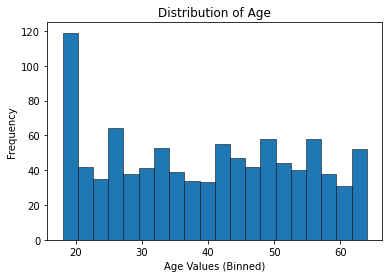

In [30]:
plt.hist(train.age, bins = 20, linewidth=.5, edgecolor='black')
plt.title('Distribution of Age')
plt.ylabel('Frequency')
plt.xlabel('Age Values (Binned)')
plt.show()

The age distribution is not normal, and would be nearly uniform if not for the large number of young individuals below the age of 20. 

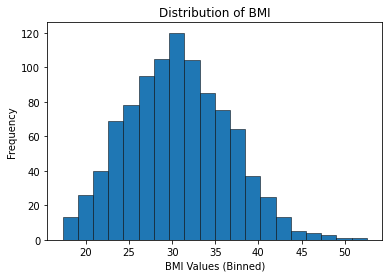

In [31]:
plt.hist(train.bmi, bins = 20, linewidth = .5, edgecolor='black')
plt.title('Distribution of BMI')
plt.ylabel('Frequency')
plt.xlabel('BMI Values (Binned)')
plt.show()

This distribution is approaching a normal distribution. As the mean rests at the obese threshold, it follows that more than half of the population is obese, with decreases proportions in the other categories moving from high weight to low weight. 

In [32]:
print(f'The percentage of individuals who are obese: {round(train.bmi_category_obese.mean() * 100, 2)}%')
print(f'The percentage of individuals who are overweight: {round(train.bmi_category_overweight.mean() * 100, 2)}%')
print(f'The percentage of individuals who are normal weight: {round(((1-train.bmi_category_obese.mean()-train.bmi_category_overweight.mean()-train.bmi_category_underweight.mean()) *100),2)}%')
print(f'The percentage of individuals who are underweight: {round(train.bmi_category_underweight.mean() * 100, 2)}%')

The percentage of individuals who are obese: 53.06%
The percentage of individuals who are overweight: 29.28%
The percentage of individuals who are normal weight: 16.51%
The percentage of individuals who are underweight: 1.14%


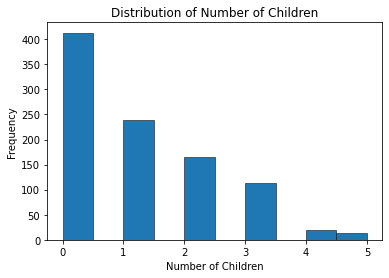

In [33]:
plt.hist(train.children, linewidth = .5, edgecolor = 'black')
plt.title('Distribution of Number of Children')
plt.ylabel('Frequency')
plt.xlabel('Number of Children')
plt.show()

This distribution is not normal. The majority of the individuals have no children with decreasing porportions of the sample representing increased number of children. 

In [34]:
train.smoker_yes.describe()

count    963.000000
mean       0.209761
std        0.407350
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: smoker_yes, dtype: float64

20.98% of the individuals in the train sample are smokers

### Statistical Testing

Now that we have looked at the summary statistics and visualized the distributions, lets explore how some of these characteristics interact with the `smoker_yes` data

### Is smoking status dependent on sex?

In [35]:
train[train.sex_male == 1].smoker_yes.mean()

0.2577962577962578

In [36]:
train[train.sex_male == 0].smoker_yes.mean()

0.16182572614107885

A greater proportion of men smoke than women. We will use a chi2 test to confirm if this difference is significant.

$H_0$: Smoking status is independent of sex

$H_a$: Smoking status is dependent on sex

In [37]:
alpha = 0.05

In [38]:
sex_smoker = pd.crosstab(train.sex_male, train.smoker_yes)
sex_smoker

smoker_yes,0,1
sex_male,,
0,404,78
1,357,124


In [39]:
chi2, p, degf, expected = stats.chi2_contingency(sex_smoker)
print('sex_smoker\n')
print(sex_smoker.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

sex_smoker

[[404  78]
 [357 124]]
---
Expected

[[380.89511942 101.10488058]
 [380.10488058 100.89511942]]
---

chi^2 = 12.8043
p     = 0.0003


In [40]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


Based on our evaluation, smoking status is dependent on sex. Sex is a good candidate for inclusion in a model.

### Is there a relationship between BMI and smoking status?

In [41]:
train[train.smoker_yes == 1].bmi.mean()

30.597475247524756

In [42]:
train[train.smoker_yes == 0].bmi.mean()

30.66796320630748

There does not appear to be any significant difference between the mean, but lets also look at how the two distributions of BMI look:

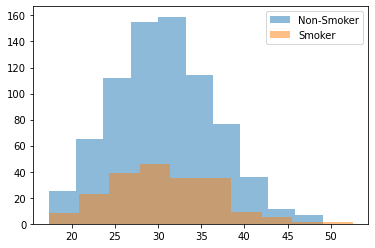

In [43]:
plt.hist(train[train.smoker_yes==0].bmi, label = 'Non-Smoker', alpha = .5)
plt.hist(train[train.smoker_yes==1].bmi, label = 'Smoker', alpha = .5)
plt.legend()

The distributions themselves also appear to be relatively similar and normal. We will run a quick t-test to confirm if there is a significant difference in the means:

$H_O$: There is no difference in the mean bmi of smokers and non-smokers

$H_a$: There is a difference in the mean bmi of smokers and non-smokers

In [44]:
stats.ttest_ind(train[train.smoker_yes==0].bmi, train[train.smoker_yes==1].bmi)

Ttest_indResult(statistic=0.15210472924352775, pvalue=0.8791362607163312)

Our p-value is well above alpha. We fail to reject the null hypothesis. This suggests that BMI may not be a good candidate in a future model. There may be some possibility that BMI combined with other factors might show differences.

Let's look at the BMI categories.

In [45]:
# Proportion of obese individuals who smoke
train[train.bmi_category_obese == 1].smoker_yes.mean()

0.20939334637964774

In [46]:
# Proportion of overweight individuals who smoke
train[train.bmi_category_overweight == 1].smoker_yes.mean()

0.19858156028368795

In [47]:
# Proportion of normal weight individuals who smoke
train[(train.bmi_category_obese != 1) & (train.bmi_category_overweight != 1) & (train.bmi_category_underweight != 1)].smoker_yes.mean()

0.23270440251572327

In [48]:
# Proportion of underweight individuals who smoke
train[train.bmi_category_underweight ==1].smoker_yes.mean()

0.18181818181818182

There do appear to be some differences between bmi categories. While the difference between obese and overweight individuals is marginal, the differences between normal weight and underweight individuals appears at first glance to be large enough to suggest a meaningful difference. Let's run a chi squared test on all four categories to first determine if there is at least one bmi group that is different from another bmi group.

In [49]:
bmi_smoker = pd.crosstab(train.bmi_category, train.smoker_yes)
bmi_smoker

smoker_yes,0,1
bmi_category,,
normal_weight,122,37
obese,404,107
overweight,226,56
underweight,9,2


The small number of observations in the underweight category will make it less likely that differences between that category and others are meaningful.

$H_0$ - Smoking status and bmi category are independent of each other

$H_a$ - Smoking status is dependent on bmi category

In [50]:
chi2, p, degf, expected = stats.chi2_contingency(bmi_smoker)
print('bmi_smoker\n')
print(bmi_smoker.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

bmi_smoker

[[122  37]
 [404 107]
 [226  56]
 [  9   2]]
---
Expected

[[125.64797508  33.35202492]
 [403.81204569 107.18795431]
 [222.84735202  59.15264798]
 [  8.69262721   2.30737279]]
---

chi^2 = 0.7698
p     = 0.8567


In [51]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We fail to reject the null hypothesis


As expected, there are not enough observations within these sub-categories to support rejecting the null hypothesis. There does not appear to be a relationship between BMI and smoking. 

### Is there a relationship between number of children and smoking status?

In [52]:
train[train.smoker_yes == 1].children.mean()

1.0792079207920793

In [53]:
train[train.smoker_yes == 0].children.mean()

1.0985545335085414

There does not appear to be a difference in the number of children that smokers have vs. non-smokers. We can test that marginal difference with a t-test.

$H_0$ - There is no difference in the mean number of children for smokers vs. non-smokers

$H_a$ - There is a difference in the mean number of children for smokers vs. non-smokers

In [54]:
stats.ttest_ind(train[train.smoker_yes==0].children, train[train.smoker_yes==1].children)

Ttest_indResult(statistic=0.20177131424578773, pvalue=0.8401382101761781)

Our p-value is higher than alpha. We fail to reject the null hypothesis.

### Is there a relationship between region and smoking status?

In [55]:
train.region.value_counts()

southeast    261
northwest    247
southwest    235
northeast    220
Name: region, dtype: int64

In [56]:
# Proportion of smokers in the southeast region
train[train.region == 'southeast'].smoker_yes.mean()

0.26436781609195403

In [57]:
# Proportion of smokers in the northwest region
train[train.region == 'northwest'].smoker_yes.mean()

0.17813765182186234

In [58]:
# Proportion of smokers in the southwest region
train[train.region == 'southwest'].smoker_yes.mean()

0.18723404255319148

In [59]:
# Proportion of smokers in the northeast region
train[train.region == 'northeast'].smoker_yes.mean()

0.20454545454545456

There appear to be differences that are large enough with enough observations to suggest that smoking status is dependent on the region that one is labeled with. We can confirm this with a chi-squared test.

$H_0$ - Smoking status is independent of region

$H_a$ - Smoking status is dependent on region

In [60]:
region_smoker = pd.crosstab(train.region, train.smoker_yes)
region_smoker

smoker_yes,0,1
region,,
northeast,175,45
northwest,203,44
southeast,192,69
southwest,191,44


In [61]:
chi2, p, degf, expected = stats.chi2_contingency(region_smoker)
print('region_smoker\n')
print(region_smoker.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

region_smoker

[[175  45]
 [203  44]
 [192  69]
 [191  44]]
---
Expected

[[173.85254413  46.14745587]
 [195.18899273  51.81100727]
 [206.25233645  54.74766355]
 [185.70612669  49.29387331]]
---

chi^2 = 6.9408
p     = 0.0738


In [62]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We fail to reject the null hypothesis


In this test, our p-value almost was lower than alpha, but it still appears that there are not enough observations with these proportions to conclusively suggest that these differences are not due to chance alone. 

### Are there any correlations between any of the numeric variables in our data?

In [63]:
def corr_plot(df):
    """
    Takes in a dataframe and returns a correlation plot of all of the numeric variables
    """
    all_features = df.columns.to_list()
    plotted_features = []
    for feature in all_features:
        if df[feature].dtype != 'object':
            plotted_features.append(feature)
    corr = df[plotted_features].corr()
    plt.rc('font',size=11)
    plt.rc('figure', figsize=(13,7))
    sns.heatmap(corr, cmap='Blues', annot=True)

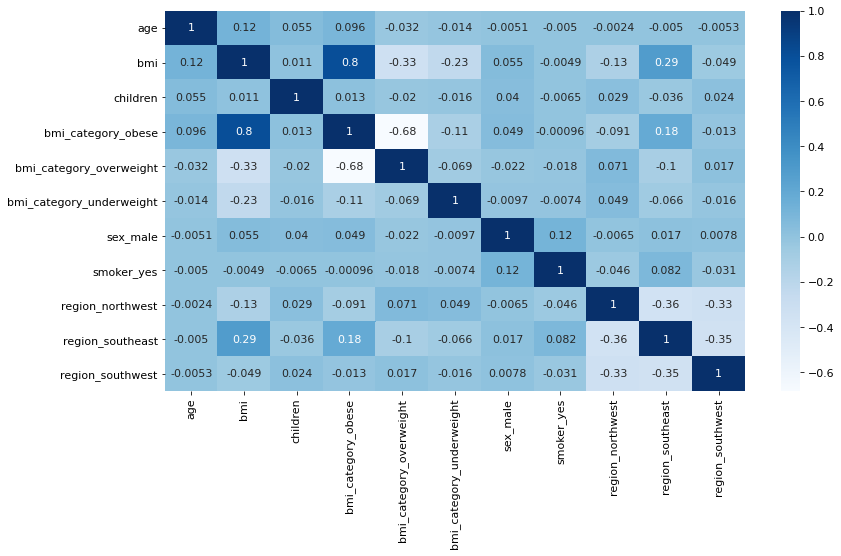

In [64]:
corr_plot(train)

#### Takeaways:
- Aside from the obvious connections between the bmi categories and bmi, there are some correlations between region_southeast and bmi, region_southeast and smoker_yes, and sex_male and smoker_yes. There may also be a case for the use of clustering if a pairplot shows evidence of non-linear relationships.

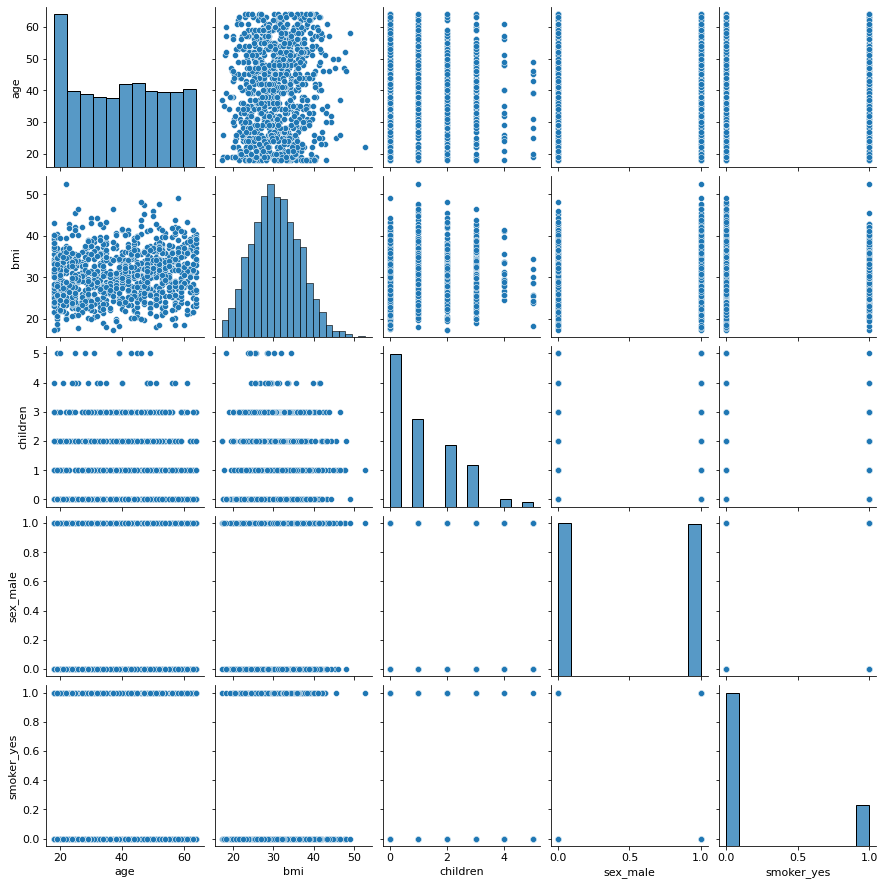

In [65]:
sns.pairplot(train[['age', 'bmi', 'children', 'sex_male', 'smoker_yes']])

#### Takeways:
- Based on visual inspection of the pairplot, there is not a strong case for the presence of non-linear relationships. 

## Clustering to Develop New Categorical Variables

### Cluster Set 1: `age`, `bmi`, `children`

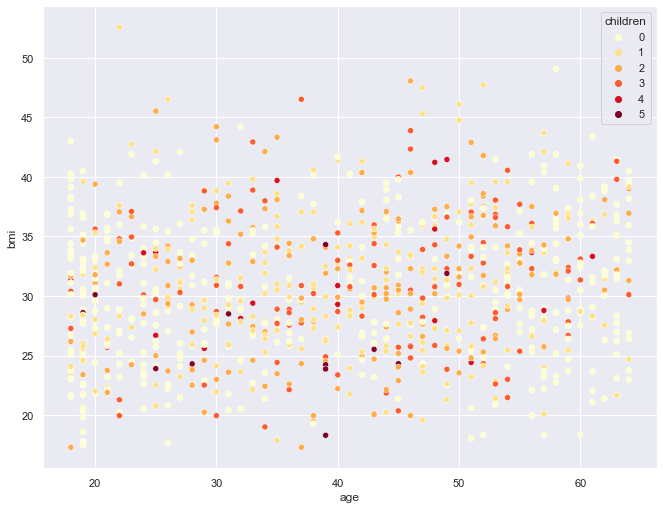

In [66]:
#Visualizing Set #1
sns.set(rc={'figure.figsize':(11,8.5)})
sns.scatterplot(data=train, x='age', y='bmi', hue='children', palette='YlOrRd')
plt.show()

In [67]:
#Creating the dataframe for the first clustering set
X1 = x_train_scaled[['age', 'bmi', 'children']]

#Creating and fitting the model on the scaled training data
kmeans1 = KMeans(n_clusters=3, random_state=528) 
kmeans1.fit(X1)

#Adding the results of the model to the unscaled train dataframe
train['age_bmi_children_cluster'] = kmeans1.predict(X1)
train.head()

,age,sex,bmi,children,smoker,region,bmi_category,bmi_category_obese,bmi_category_overweight,bmi_category_underweight,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_bmi_children_cluster
1145,52,male,32.775,3,no,northwest,obese,1,0,0,1,0,1,0,0,2
619,55,female,37.100,0,no,southwest,obese,1,0,0,0,0,0,0,1,0
776,40,male,32.300,2,no,northwest,obese,1,0,0,1,0,1,0,0,2
176,38,male,27.835,2,no,northwest,overweight,0,1,0,1,0,1,0,0,2
805,45,female,35.815,0,no,northwest,obese,1,0,0,0,0,1,0,0,0


In [68]:
train.age_bmi_children_cluster.value_counts()

1    372
0    337
2    254
Name: age_bmi_children_cluster, dtype: int64

In [69]:
# Cluster 0 descriptive statistics
train[train.age_bmi_children_cluster == 0].describe()

,age,bmi,children,bmi_category_obese,bmi_category_overweight,bmi_category_underweight,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_bmi_children_cluster
count,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.0
mean,52.985163,31.362864,0.501484,0.584570,0.272997,0.011869,0.489614,0.195846,0.234421,0.278932,0.246291,0.0
std,7.119082,5.905437,0.612978,0.493529,0.446162,0.108459,0.500635,0.397440,0.424267,0.449141,0.431491,0.0
min,40.000000,18.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,47.000000,27.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,54.000000,31.350000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,59.000000,35.910000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0
max,64.000000,49.060000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [70]:
# Cluster 1 descriptive statistics
train[train.age_bmi_children_cluster == 1].describe()

,age,bmi,children,bmi_category_obese,bmi_category_overweight,bmi_category_underweight,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_bmi_children_cluster
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.0
mean,25.682796,29.899960,0.497312,0.470430,0.327957,0.013441,0.481183,0.217742,0.252688,0.293011,0.231183,1.0
std,6.290490,5.674255,0.670915,0.499797,0.470101,0.115308,0.500319,0.413267,0.435139,0.455756,0.422157,0.0
min,18.000000,17.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,20.000000,25.926250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,25.000000,29.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,31.000000,33.637500,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0
max,39.000000,52.580000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [71]:
# Cluster 2 descriptive statistics
train[train.age_bmi_children_cluster == 2].describe()

,age,bmi,children,bmi_category_obese,bmi_category_overweight,bmi_category_underweight,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_bmi_children_cluster
count,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.0
mean,41.330709,30.814724,2.755906,0.547244,0.267717,0.007874,0.539370,0.216535,0.291339,0.228346,0.259843,2.0
std,10.282611,5.929293,0.807245,0.498746,0.443643,0.088560,0.499432,0.412696,0.455276,0.420596,0.439414,0.0
min,18.000000,17.290000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,34.000000,26.336250,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
50%,42.000000,30.542500,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.0
75%,49.000000,34.800000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.0
max,64.000000,48.070000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0


In [72]:
train.groupby('age_bmi_children_cluster').smoker_yes.describe()

,count,mean,std,min,25%,50%,75%,max
age_bmi_children_cluster,,,,,,,,
0,337.0,0.195846,0.397440,0.0,0.0,0.0,0.0,1.0
1,372.0,0.217742,0.413267,0.0,0.0,0.0,0.0,1.0
2,254.0,0.216535,0.412696,0.0,0.0,0.0,0.0,1.0


While the KMeans clustering algorithm was able to identify several clusters, the differences in the smoking rates within each of the clusters appear to be quite small, and may not represent any meaningful difference. Let's confirm with a chi-squared analysis:

$H_0$ - Smoking status is not dependent on cluster

$H_a$ - Smoking status is dependent on cluster

In [73]:
cluster_smoker = pd.crosstab(train.age_bmi_children_cluster, train.smoker_yes)
cluster_smoker

smoker_yes,0,1
age_bmi_children_cluster,,
0,271,66
1,291,81
2,199,55


In [74]:
chi2, p, degf, expected = stats.chi2_contingency(cluster_smoker)
print('cluster_smoker\n')
print(cluster_smoker.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

cluster_smoker

[[271  66]
 [291  81]
 [199  55]]
---
Expected

[[266.31048806  70.68951194]
 [293.96884735  78.03115265]
 [200.72066459  53.27933541]]
---

chi^2 = 0.6069
p     = 0.7383


As expected, the p-value is quite large. We fail to reject the null hypothesis. We will not promote the use of cluster as a modeling feature.

# Modeling
At this point we will begin to create classification models to predict smoker status using the following algorithms:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. K-Nearest Neighbors

We can begin by establishing a baseline simply by choosing the most common result for smoker_yes: 0

In [108]:
1 - y_train.mean()

0.7902388369678089

In [77]:
x_train_scaled

,age,bmi,children,bmi_category_obese,bmi_category_overweight,bmi_category_underweight,sex_male,region_northwest,region_southeast,region_southwest
1145,0.739130,0.438793,0.6,1.0,0.0,0.0,1.0,1.0,0.0,0.0
619,0.804348,0.561349,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
776,0.478261,0.425333,0.4,1.0,0.0,0.0,1.0,1.0,0.0,0.0
176,0.434783,0.298810,0.4,0.0,1.0,0.0,1.0,1.0,0.0,0.0
805,0.586957,0.524936,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
145,0.239130,0.610371,0.6,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1210,0.391304,0.384953,0.2,1.0,0.0,0.0,1.0,1.0,0.0,0.0
188,0.500000,0.422499,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0
432,0.521739,0.272315,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## Logistic Regression

In [93]:
logit = LogisticRegression(random_state=123)

In [94]:
logit.fit(x_train_scaled, y_train)

LogisticRegression(random_state=123)

In [95]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.00125    -0.32535316 -0.07224743 -0.12908028 -0.16233692 -0.16123459
   0.58146025 -0.16783722  0.36425518 -0.10757324]]
Intercept: 
 [-1.42606469]


In [96]:
y_pred = logit.predict(x_train_scaled)

In [103]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [98]:
y_pred_proba = logit.predict_proba(x_train_scaled)

In [109]:
y_pred_proba

array([[0.79060184, 0.20939816],
       [0.86369919, 0.13630081],
       [0.7874131 , 0.2125869 ],
       ...,
       [0.85999569, 0.14000431],
       [0.76919394, 0.23080606],
       [0.71529343, 0.28470657]])

In [99]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(x_train_scaled, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.79


In [106]:
print(confusion_matrix(y_train, y_pred))

[[761   0]
 [202   0]]


In [107]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       761
           1       0.00      0.00      0.00       202

    accuracy                           0.79       963
   macro avg       0.40      0.50      0.44       963
weighted avg       0.62      0.79      0.70       963



#### Takeaway:
While individuals had different probabilities for being a smoker vs. a non-smoker, no individual's probability for smoking exceeded 50%. Thus, the model predicted every record to be a non-smoker, which is identical to our baseline model.

## Decision Tree

In [111]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [112]:
clf.fit(x_train_scaled, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [113]:
y_pred2 = clf.predict(x_train_scaled)
y_pred2[0:5]

array([0, 0, 0, 0, 0], dtype=uint8)

In [114]:
y_pred_proba2 = clf.predict_proba(x_train_scaled)
y_pred_proba2[0:5]

array([[0.73880597, 0.26119403],
       [0.8647541 , 0.1352459 ],
       [0.73880597, 0.26119403],
       [0.73880597, 0.26119403],
       [0.8647541 , 0.1352459 ]])

In [115]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(x_train_scaled, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


In [116]:
confusion_matrix(y_train, y_pred2)

array([[756,   5],
       [193,   9]])

In [117]:
print(classification_report(y_train, y_pred2))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88       761
           1       0.64      0.04      0.08       202

    accuracy                           0.79       963
   macro avg       0.72      0.52      0.48       963
weighted avg       0.76      0.79      0.72       963



#### Takeaway:
Somewhat humorously, while our decision tree model at least had some variation in its predictions (14 individuals were predicted to be smokers), the accuracy ended up being identical to both baseline and logistic regression.

## Random Forest

In [119]:
rf = RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [120]:
rf.fit(x_train_scaled, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [121]:
print(rf.feature_importances_)

[0.22299131 0.25431992 0.1032133  0.01755196 0.01503995 0.00169955
 0.21030264 0.04302473 0.10027638 0.03158025]


In [122]:
y_pred3 = rf.predict(x_train_scaled)

In [123]:
y_pred_proba3 = rf.predict_proba(x_train_scaled)

In [124]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(x_train_scaled, y_train)))

Accuracy of random forest classifier on training set: 0.79


In [125]:
print(confusion_matrix(y_train, y_pred3))

[[761   0]
 [202   0]]


In [126]:
print(classification_report(y_train, y_pred3))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       761
           1       0.00      0.00      0.00       202

    accuracy                           0.79       963
   macro avg       0.40      0.50      0.44       963
weighted avg       0.62      0.79      0.70       963



#### Takeaway:
Looks like we are back at baseline again. Everyone is a non-smoker according to this model.

## KNN

In [128]:
knn = KNeighborsClassifier(n_neighbors=30, weights='uniform')

In [130]:
knn.fit(x_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=30)

In [131]:
y_pred4 = knn.predict(x_train_scaled)

In [132]:
y_pred_proba4 = knn.predict_proba(x_train_scaled)

In [133]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(x_train_scaled, y_train)))

Accuracy of KNN classifier on training set: 0.79


In [134]:
print(confusion_matrix(y_train, y_pred4))

[[761   0]
 [202   0]]


In [135]:
print(classification_report(y_train, y_pred4))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       761
           1       0.00      0.00      0.00       202

    accuracy                           0.79       963
   macro avg       0.40      0.50      0.44       963
weighted avg       0.62      0.79      0.70       963



# Conclusion

No model performed better than baseline. This is not surprising, given that during exploration, the only characteristic that had a weak correlation with smoker status was sex, but it appears that the influence of sex isn't large enough to push any probabilities toward smoker status. The DecisionTree had the most promising performance, if only because it predicted at least a handful of smokers. 

Nevertheless, at this time, with so little improvement on our baseline, there is no need to continue to validate and test these models. 